## Similarity-based Search Prediction

This notebook shows an example use of the similarity-basead search prediction models presented in the paper
"Vessel Trajectory Prediction Using Historical Automatic Identification System Data" (2020) by Alizadeh et al.,
doi: 10.1017/S0373463320000442.

In [1]:

import matplotlib.pyplot as plt
import numpy as np

from prediction.model.pssp import PSSP
from prediction.model.tssp import TSSP
from prediction.model.tsspl import TSSPL

### Diverging Trajectories

This first example shows how the different models predict the future trajectory of a vessel where the trajectory so far
is diverging from the historical data. As described in the paper, only the model using the LSTM for predicting dynamic
spatial distances is able to predict the future trajectory in this case.

Epoch 1/5, Loss: 0.0022
Epoch 2/5, Loss: 0.0001
Epoch 3/5, Loss: 0.0000
Epoch 4/5, Loss: 0.0000
Epoch 5/5, Loss: 0.0000


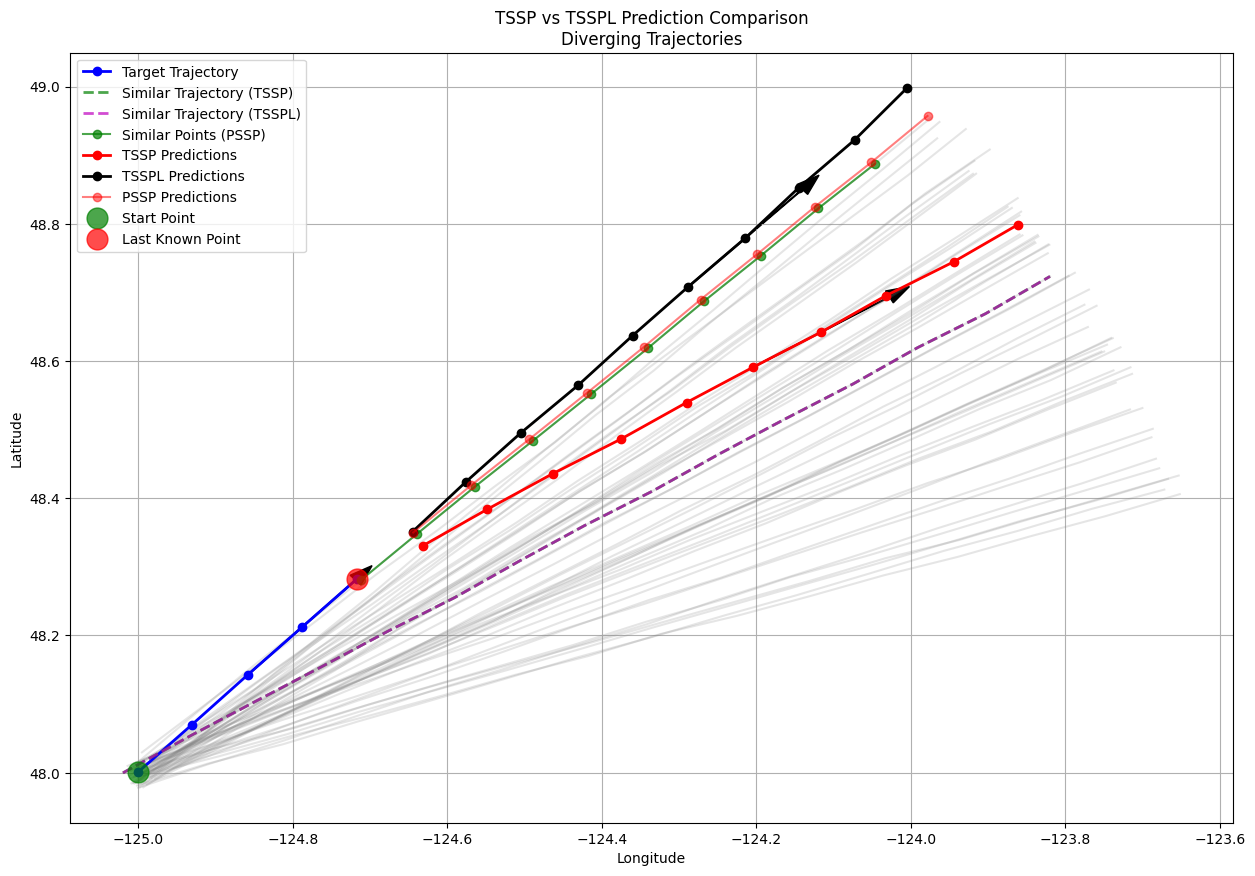

In [8]:
np.random.seed(42)

def generate_diverging_trajectory(
    start_lat: float,
    start_lon: float,
    angle: float,
    points: int = 10,
    speed: float = 0.1,
    noise: float = 0.001,
) -> np.ndarray:
    """Generate a trajectory that moves at a specified angle.

    Args:
        start_lat: Starting latitude
        start_lon: Starting longitude
        angle: Angle in degrees (0 = East, 90 = North)
        points: Number of points in trajectory
        speed: Distance between points
        noise: Amount of random noise to add
    """
    trajectory = np.zeros((points, 4))
    angle_rad = np.radians(angle)

    for i in range(points):
        # Calculate position with some noise
        lat = start_lat + i * speed * np.sin(angle_rad) + np.random.normal(0, noise)
        lon = start_lon + i * speed * np.cos(angle_rad) + np.random.normal(0, noise)

        # Add some noise to speed and course
        trajectory[i] = [
            lat,
            lon,
            15 + np.random.normal(0, 0.5),  # speed
            angle + np.random.normal(0, 2),  # course
        ]

    return trajectory

def create_diverging_dataset(n_similar_tracks: int = 10) -> list[np.ndarray]:
    """Create a dataset with groups of similar but diverging trajectories."""
    database = []

    # Create several similar trajectories that start parallel but gradually diverge
    base_angles = [20, 25, 30, 35, 40]  # Different diverging angles

    for angle in base_angles:
        # Create several trajectories with slight variations
        for _ in range(n_similar_tracks):
            # Add small random variation to angle and starting position
            angle_var = angle + np.random.normal(0, 2)
            start_lat = 48.0 + np.random.normal(0, 0.01)
            start_lon = -125.0 + np.random.normal(0, 0.01)

            traj = generate_diverging_trajectory(
                start_lat=start_lat, start_lon=start_lon, angle=angle_var, points=15
            )
            database.append(traj)

    return database


# Create test data
database = create_diverging_dataset()
target_traj = generate_diverging_trajectory(
    start_lat=48.0, start_lon=-125.0, angle=45, points=5  # Target trajectory diverges more sharply
)

pssp = PSSP(database)
tssp = TSSP(database)
tsspl = TSSPL(database, n_epochs=5)

# Make predictions
n_steps = 10
pssp_predictions, pssp_similar = pssp.predict(target_traj[-1], n_steps)
tssp_predictions, tssp_similar = tssp.predict(target_traj, n_steps)
tsspl_predictions, tsspl_similar = tsspl.predict(target_traj, n_steps)

# Plotting
plt.figure(figsize=(15, 10))

# Plot database trajectories in light gray
for traj in database:
    plt.plot(traj[:, 1], traj[:, 0], "gray", alpha=0.2)

# Plot target trajectory
plt.plot(target_traj[:, 1], target_traj[:, 0], "b-o", label="Target Trajectory", linewidth=2)

# Plot similar trajectories found by each method
plt.plot(
    tssp_similar[:, 1], tssp_similar[:, 0], "g--", label="Similar Trajectory (TSSP)", alpha=0.7, linewidth=2
)
plt.plot(
    tsspl_similar[:, 1],
    tsspl_similar[:, 0],
    "m--",
    label="Similar Trajectory (TSSPL)",
    alpha=0.7,
    linewidth=2,
)
plt.plot(pssp_similar[:, 1], pssp_similar[:, 0], "g-o", label="Similar Points (PSSP)", alpha=0.7)

# Plot predictions
plt.plot(tssp_predictions[:, 1], tssp_predictions[:, 0], "r-o", label="TSSP Predictions", linewidth=2)
plt.plot(tsspl_predictions[:, 1], tsspl_predictions[:, 0], "k-o", label="TSSPL Predictions", linewidth=2)
plt.plot(pssp_predictions[:, 1], pssp_predictions[:, 0], "r-o", label="PSSP Predictions", alpha=0.5)

# Add start and end markers
plt.plot(target_traj[0, 1], target_traj[0, 0], "go", markersize=15, label="Start Point", alpha=0.7)
plt.plot(target_traj[-1, 1], target_traj[-1, 0], "ro", markersize=15, label="Last Known Point", alpha=0.7)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("TSSP vs TSSPL Prediction Comparison\nDiverging Trajectories")
plt.legend()
plt.grid(True)

# Add direction arrows
for traj in [target_traj, tssp_predictions, tsspl_predictions]:
    mid_point = len(traj) // 2
    dx = traj[mid_point + 1, 1] - traj[mid_point, 1]
    dy = traj[mid_point + 1, 0] - traj[mid_point, 0]
    plt.arrow(
        traj[mid_point, 1],
        traj[mid_point, 0],
        dx * 2,
        dy * 2,
        head_width=0.02,
        head_length=0.03,
        fc="k",
        ec="k",
    )

plt.show()